In [1]:
import warnings
warnings.filterwarnings("ignore") 

import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(1966)

from sklearn.cluster import KMeans

from sklearn.metrics import mutual_info_score

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [3]:
%matplotlib inline

In [4]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Functions

In [5]:
def calc_MI(accessibilities, conditions, bins):
    minac,maxac=np.min(accessibilities),np.max(accessibilities)
    bins = np.arange(minac,maxac,(maxac-minac)/bins)
    
    c_xy = []
    for condition in conditions:
        condition_ix = np.where(conditions==condition)[0]
        accessibilities_condition = accessibilities[condition_ix]
        condition_hist = np.histogram(accessibilities_condition,bins=bins)
        c_xy.append(condition_hist[0])
    
    c_xy = np.stack(c_xy)
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Hardcoded Metadata

In [6]:
#stage color coding
color_dict= {"T1 (Basal)":"#DAF7A6",
"T2":"#A1BE6C",
"T3":"#EED04D",
"T3.5":"#D4AA47",
"T4-day1":"#1D89E3",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T6":"#D16BA7",
"T7_PDAC":"#BD14DA",
"T8_LiverMet":"#63009B",
"T8_PDAC_LiverMets":"#63009B",
"T8_PDAC_LungMets":"#63009B"}

In [7]:
#order of samples along progression
order = ['DACD351_Kate_plus', 'DACD394_Kate_plus', 'DACD406_Kate_plus',
       'DACD404_Kate_plus', 'DACD407_Kate_plus', 'DAC_DI143_Epi',
       'DACD482_Kate_plus', 'DAC_C301-EPI_1', 'DAC_C301-EPI_2',
       'Ag-PDAC-PT-Kate', 'Ag-Lung-Mets-Kate', 'DAC_D020_p5_Epi',
       'DACC963PT_Kate_plus', 'DACC963LIVERmet', 'DACC963_mKate_plus'] #K1-K6

In [8]:
stage_dict = {'184RH_PDAC-PT_KATE_GFP': 'T7_PDAC',
 '184RRH_LIVmet': 'T8_PDAC_LiverMets',
 'Ag-PDAC-PT-Kate': 'T7_PDAC',
 'D396_EPI': 'T3.5',
 'DAC_B528-Kate+': 'T4',
 'DAC_B530-Kate+': 'T2',
 'DAC_C263_EPI': 'T3.5',
 'DAC_C269_EPI': 'T5',
 'DAC_C301-EPI_1': 'T6',
 'DAC_C301-EPI_2': 'T6',
 'DAC_D020_p5_Epi': 'T7_PDAC',
 'DAC_DI143_Epi': 'T5',
 'DACC963_mKate_plus': 'T8_PDAC_LungMets',
 'DACC963LIVERmet': 'T8_LiverMet',
 'DACC963PT_Kate_plus': 'T7_PDAC',
 'DACD351_Kate_plus': 'T3',
 'DACD394_Kate_plus': 'T3',
 'DACD403_Kate_plus': 'T2',
 'DACD404_Kate_plus': 'T4',
 'DACD406_Kate_plus': 'T3',
 'DACD407_Kate_plus': 'T4-day1',
 'DACD482_Kate_plus': 'T5',
 'Ag-Lung-Mets-Kate': 'T8_PDAC_LungMets',
 'DACD511_Kate_plus': 'T1 (Basal)',
 'DACD550_kate_plus': 'T1 (Basal)'}

In [9]:
#this combines mets into one coherent stage and combines 24-48hpi samples
stage_dict_simple = {'184RH_PDAC-PT_KATE_GFP': 'T7_PDAC',
 '184RRH_LIVmet': 'T8_PDAC',
 'Ag-PDAC-PT-Kate': 'T7_PDAC',
 'D396_EPI': 'T3.5',
 'DAC_B528-Kate+': 'T4',
 'DAC_B530-Kate+': 'T2',
 'DAC_C263_EPI': 'T3.5',
 'DAC_C269_EPI': 'T5',
 'DAC_C301-EPI_1': 'T6',
 'DAC_C301-EPI_2': 'T6',
 'DAC_D020_p5_Epi': 'T7_PDAC',
 'DAC_DI143_Epi': 'T5',
 'DACC963_mKate_plus': 'T8_PDAC',
 'DACC963LIVERmet': 'T8_PDAC',
 'DACC963PT_Kate_plus': 'T7_PDAC',
 'DACD351_Kate_plus': 'T3',
 'DACD394_Kate_plus': 'T3',
 'DACD403_Kate_plus': 'T2',
 'DACD404_Kate_plus': 'T4',
 'DACD406_Kate_plus': 'T3',
 'DACD407_Kate_plus': 'T4',
 'DACD482_Kate_plus': 'T5',
 'Ag-Lung-Mets-Kate': 'T8_PDAC',
 'DACD511_Kate_plus': 'T1 (Basal)',
  'DACD550_kate_plus': 'T1 (Basal)'}

# Load Original scRNA Data

In [10]:
sc = load_sc(working_dir+"saved_analyses/T3-T8_EC2-AllGenes.pickle")

#get HVGs
sc2 = load_sc(working_dir+"saved_analyses/T3-T8_EC2.pickle")
hvgs = list(sc2.data_normalized)
del sc2

In [11]:
stages = np.array([stage_dict_simple[sample] for sample in sc.sample_ids])
injury = np.where(stages=='T4')[0]
kras = np.where(stages=='T3')[0]

In [12]:
#various normalizations
data_zscored = ((sc.data_normalized.T - sc.data_normalized.mean(1).values)/sc.data_normalized.std(1).values).T
data_logged = np.log2(sc.data_normalized+.1)
data_logged_zscored = ((data_logged.T-data_logged.mean(1).values)/data_logged.std(1).values).T
data_logged_zscored2 = (data_logged-data_logged.mean(0).values)/data_logged.std(0).values

# Load Bulk ATAC Data

In [13]:
peaks = pd.read_csv(working_dir+"misc_files/ATAC_reanalysis_T4T5_2022-02-07/Table_DAC_pancATAC_normCounts_crctd_uscore.txt",sep='\t',index_col=0)

In [14]:
labels = pd.read_csv(working_dir+"misc_files/ATAC_reanalysis_T4T5_2022-02-07/Table_DAC_pancATAC_Annot_uscore.txt",sep='\t',index_col=0)
labels

,Group
Sample,
D13_2,T1_Normal
D7_3,T1_Normal
D1_2,T1_Normal
D8_2,T2_RegADM
D8_3,T2_RegADM
D11_1,T2_RegADM
D14_2,T2_RegADM
D6_1,T2_RegADM
D6_3,T3_KrasG12D


In [15]:
order_ =  ['D13_2', 'D7_3', 'D1_2', 'D8_2', 'D8_3', 'D11_1', 'D14_2', 'D6_1',
       'D6_3', 'D8_1', 'D13_3', 'D7_1', 'D18_3', 'D19_1', 'D19_3', 'D4_2',
       'D11_3', 'D1_1', 'D23_1', 'D13_1', 'D21_2', 'D21_3',
     'D2_1', 'D12_1', 'D12_2', 'D22_3', 'J16_1', 'J16_2']

labels_order = labels.loc[order_]['Group'].values
peaks = peaks[order_]

color_dict2 = {'T1_Normal':color_dict['T1 (Basal)'],
             'T2_RegADM':color_dict['T2'],
             'T3_KrasG12D':color_dict['T3'],
             'T4_TumADR':color_dict['T4'],
             'T7_PDAC':color_dict['T7_PDAC'],
             'T7_PDAC(CL)':color_dict['T7_PDAC'],
             'T5_PanIN_early':color_dict['T5'],
             'T6_PanIN_late':color_dict['T6'],
              'T8_PDAC_2D':color_dict['T8_PDAC_LiverMets']}

labels_colors = [color_dict2[label] for label in labels_order]
labels_colors_rgb = [matplotlib.colors.to_rgb(col) for col in labels_colors]

In [16]:
#original analysis also had samples: 'D9_1', 'D3_2', 'D3_3'

In [17]:
#select peaks of interest
def reformat_peak(coord):
    return "{}_{}_{}".format(coord[0],coord[1],coord[2])

peaks_all = []
genes_all = []

comparisons = '''DiffPeaks_T5_vs_T1
DiffPeaks_T5_vs_T2
DiffPeaks_T5_vs_T3
DiffPeaks_T5_vs_T4
DiffPeaks_T6_vs_T1
DiffPeaks_T6_vs_T2
DiffPeaks_T6_vs_T3
DiffPeaks_T6_vs_T4
DiffPeaks_T6_vs_T5'''.split("\n") #only early comparisons


for comparison in comparisons:
    peaks_comparison_1 = pd.read_csv(working_dir+"misc_files/ATAC_reanalysis_T4T5_2022-02-07/{}/Table_DESeq2_SignificantUpregulated_Annotated.txt".format(comparison),
                                   sep='\t',index_col=0)
    peaks_comparison_1_coord = [reformat_peak(peaks_comparison_1.iloc[i][['seqnames','start','end']].values) for i in range(peaks_comparison_1.shape[0])]
    peaks_comparison_2 = pd.read_csv(working_dir+"misc_files/ATAC_reanalysis_T4T5_2022-02-07/{}/Table_DESeq2_SignificantDownregulated_Annotated.txt".format(comparison),
                                   sep='\t',index_col=0)
    peaks_comparison_2_coord = [reformat_peak(peaks_comparison_2.iloc[i][['seqnames','start','end']].values) for i in range(peaks_comparison_2.shape[0])]

    peaks_to_add = np.concatenate((peaks_comparison_1_coord,peaks_comparison_2_coord))
    genes_to_add = np.concatenate((peaks_comparison_1['SYMBOL'].values,peaks_comparison_2['SYMBOL'].values))
    
    peaks_all.append(peaks_to_add)
    genes_all.append(genes_to_add)

In [18]:
peak_gene_df = pd.DataFrame(dict(peaks=np.concatenate(peaks_all),genes=np.concatenate(genes_all)))

In [19]:
peak_gene_df

,peaks,genes
0,chr8_67001144_67002338,Mir710
1,chr13_18066988_18068487,Yae1d1
2,chr8_60941964_60943058,Gm15881
3,chr2_22579388_22580226,Apbb1ip
4,chr7_66077287_66078684,Atp10a
...,...,...
184112,chr6_104546929_104547844,Cntn6
184113,chr7_99728942_99729539,Ccdc90b
184114,chr4_111573938_111574587,Slc5a9
184115,chr9_11911683_11912151,Cntn5


In [20]:
peaks_old = pd.read_csv("/Users/burdziac/Documents/PDAC/misc/Table_DESeq2_FilteredNormalizedCounts_PeakNorm_T4_K6_Named.csv",header=1).dropna()

In [21]:
peaks_old['peaks']=peaks_old['Peak']
peaks_old['genes']=peaks_old['Gene']

In [22]:
peak_gene_df = pd.concat((peak_gene_df,peaks_old[['peaks','genes']]))
peak_gene_df

,peaks,genes
0,chr8_67001144_67002338,Mir710
1,chr13_18066988_18068487,Yae1d1
2,chr8_60941964_60943058,Gm15881
3,chr2_22579388_22580226,Apbb1ip
4,chr7_66077287_66078684,Atp10a
...,...,...
103906,chrX_165561006_165562039,Arhgap6
103907,chrX_165647841_165648492,Arhgap6
103910,chrX_165756769_165758737,Gm15246
103915,chrX_166129185_166130323,Mid1


In [23]:
peak_gene_df = peak_gene_df.drop_duplicates("peaks")

In [24]:
peaks = peaks.loc[peak_gene_df['peaks']] #select differential peaks
peaks_genes = peak_gene_df['genes']

In [25]:
peaks_log = np.log1p(peaks)

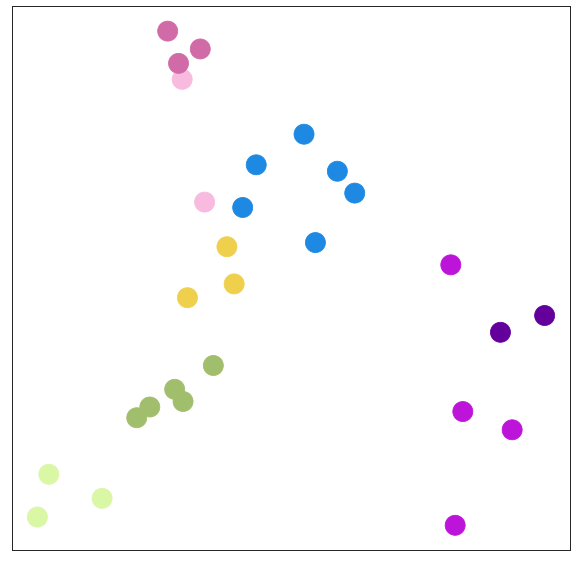

In [26]:
pc = PCA(n_components=2)
pca = pc.fit_transform(peaks_log.T)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.scatter(pca[:,0],pca[:,1],c=labels_colors,s=400)
ax.set_xticks([])
ax.set_yticks([]);

plt.savefig(working_dir+"final_figures/Figure2/BulkATACseq_PCA.png",bbox_inches='tight')
plt.savefig(working_dir+"final_figures/Figure2/BulkATACseq_PCA.svg",bbox_inches='tight')

In [27]:
print(pc.explained_variance_ratio_)

[0.36130472 0.1773186 ]


# Identify Modules

In [28]:
#peak_clusters = KMeans(n_clusters=15).fit(peaks_log).labels_
#pd.DataFrame(peak_clusters).to_csv("final_outputs/Figure2/Peak_Clusters.csv",index=False,header=False)

#reading in previously computed for consistency
peak_clusters = pd.read_csv(working_dir+"final_outputs/Figure2/Peak_Clusters.csv",header=None).values.flatten()

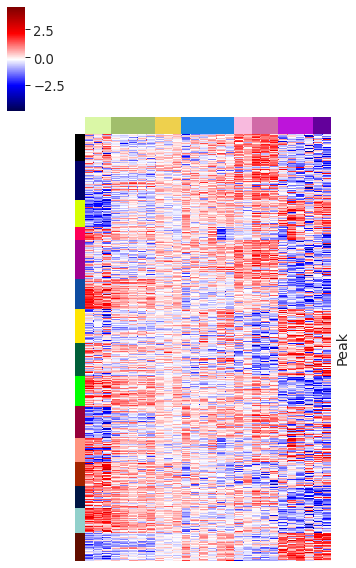

In [29]:
row_clusters = peak_clusters.copy()
row_clusters = [sc.palette[i] for i in row_clusters]
sns.clustermap(peaks_log.iloc[np.argsort(peak_clusters),:], col_cluster=False, row_cluster=False,
               xticklabels="", yticklabels="",figsize=(5,8),
               col_colors=labels_colors,row_colors=np.array(row_clusters)[np.argsort(peak_clusters)],
               cmap='seismic', z_score=0,vmax=4.5)

## Visualize Coherent Module Patterns

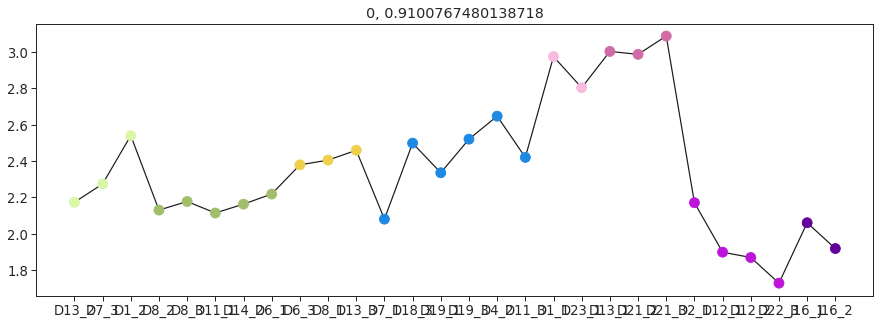

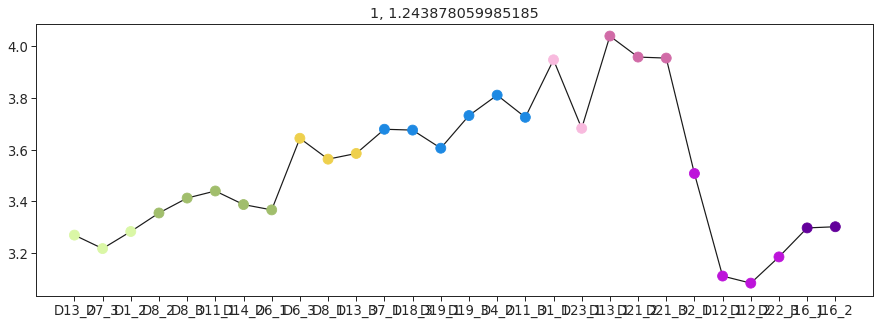

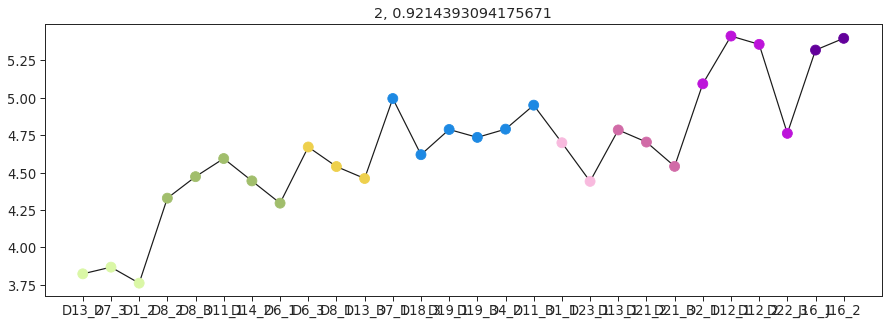

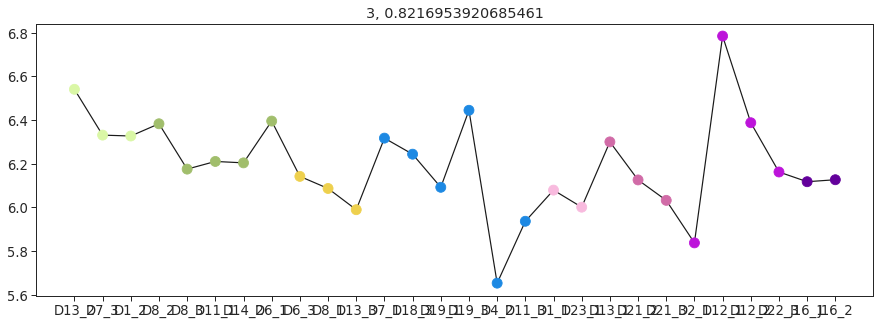

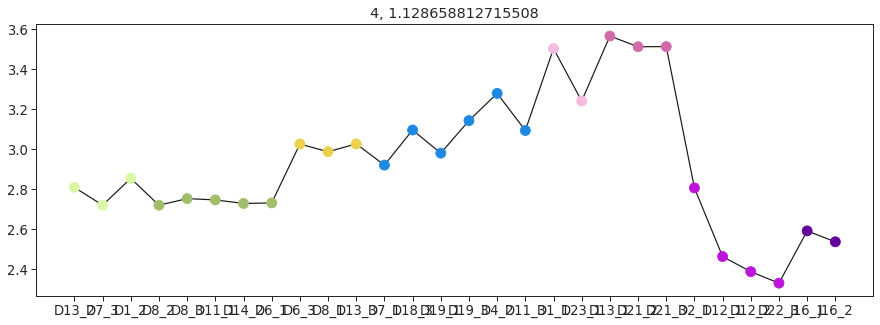

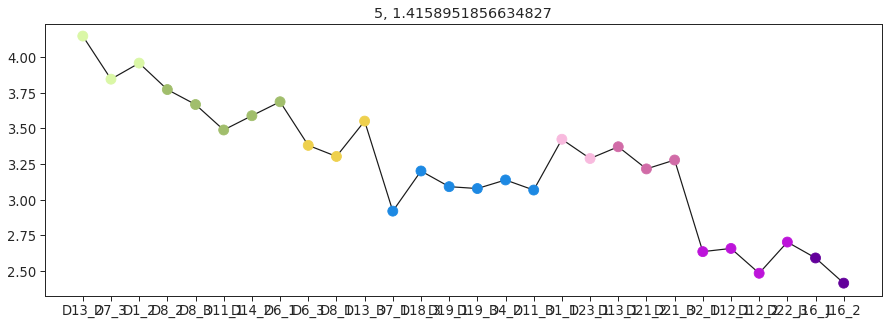

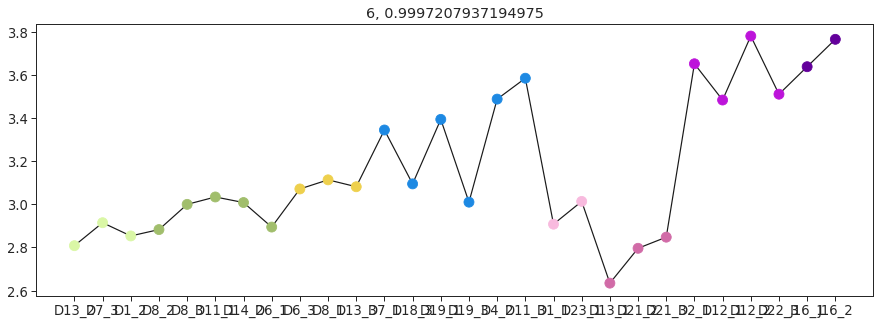

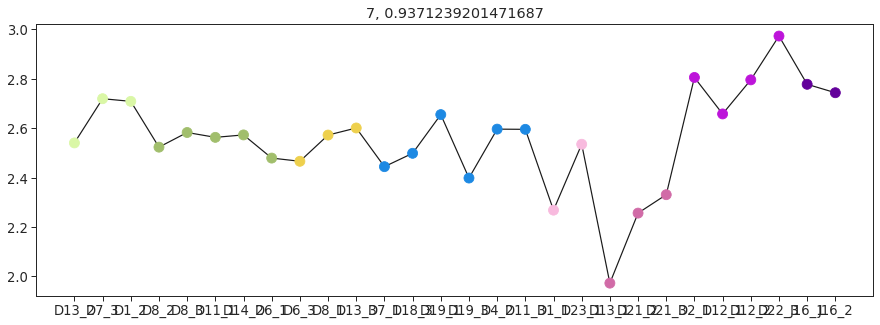

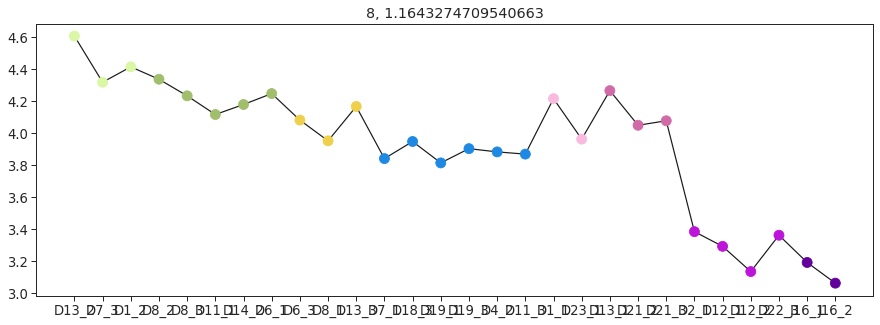

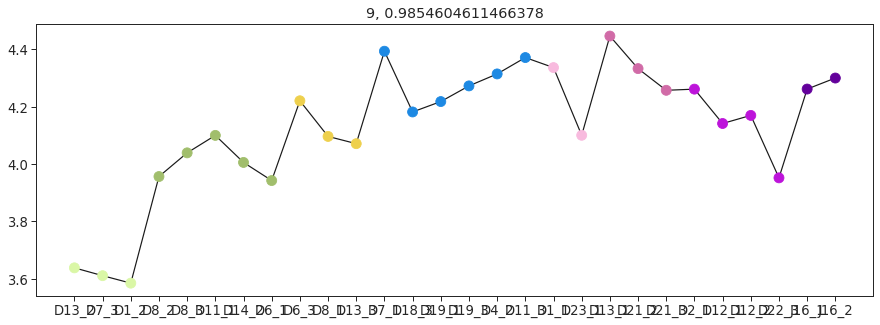

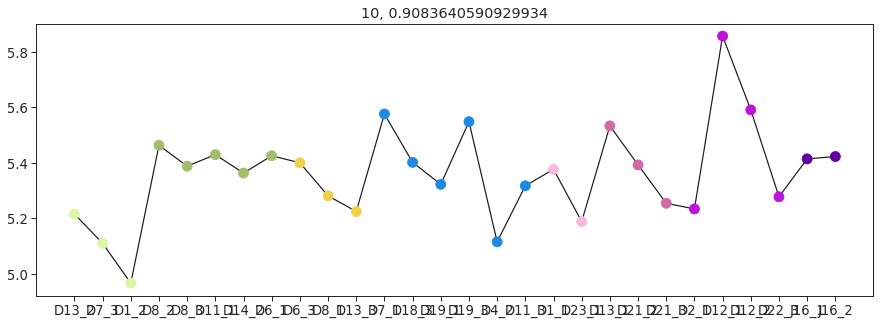

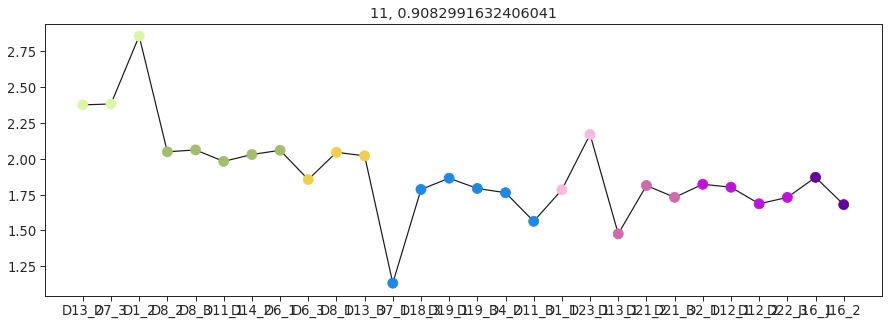

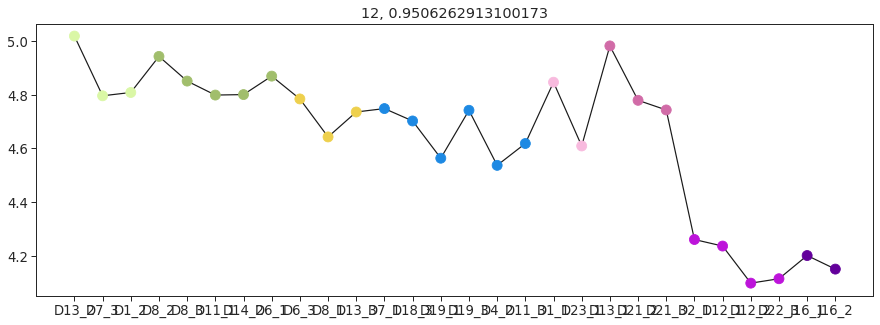

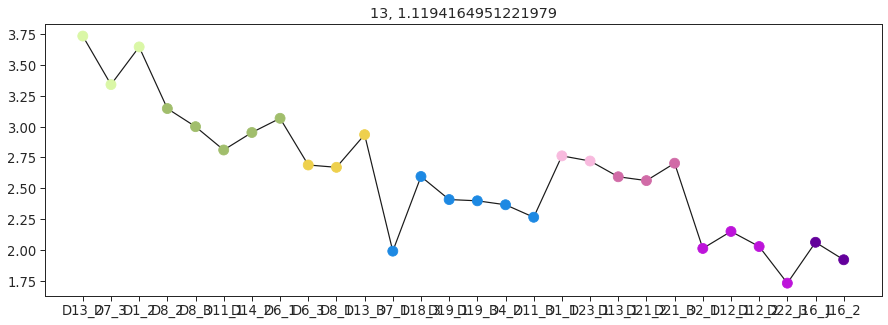

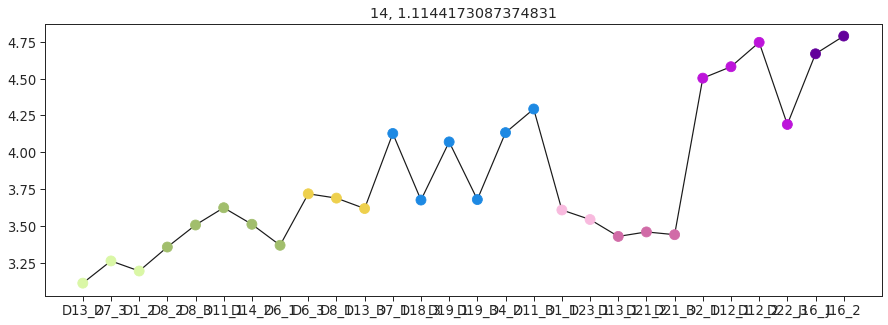

In [30]:
cluster_patterns = []
MIs = []
for cluster in set(peak_clusters.flatten()):
    cluster_ix = np.where(peak_clusters.flatten()==cluster)[0]
    cluster_peaks = peaks_log.iloc[cluster_ix].median(0)
    fig,ax=plt.subplots(figsize=(15,5))
    ax.scatter(range(len(cluster_peaks)),cluster_peaks,c=labels_colors,s=100,zorder=1)
    ax.plot(cluster_peaks,c='k',zorder=0)
    ax.set_title("{}, {}".format(cluster,calc_MI(cluster_peaks,labels_order, 10)))
    MIs.append(calc_MI(cluster_peaks,labels_order, 10))
    cluster_patterns.append(cluster_peaks.values)

In [31]:
set(range(len(MIs)))-set(np.where(MIs>np.percentile(MIs,20))[0])

{3, 10, 11}

## Assign Modules to Patterns

In [32]:
#manual assignment to modules
ADRPDAC = [2,6,7,14]
ADRPanIN = [0,1,4,9]
Normal = [5,8,13,12]

In [33]:
labels_modules = ['Normal','Benign Neoplasia','Malignant']

module_gene_dict = {}
peak_ordering = []
i=0

for clusterset in [Normal,ADRPanIN,ADRPDAC]:
    tmp = []
    for cluster in clusterset:
        tmp.append(np.where(peak_clusters==cluster)[0])
    tmp = np.concatenate(tmp)
    genes_set = peaks_genes.values[tmp]
    genes_set = np.array(list(set([str(gene).upper() for gene in genes_set])))

    peak_ordering.append(tmp)
    module_gene_dict[labels_modules[i]] = genes_set
    i+=1
peak_ordering_concat = np.concatenate(peak_ordering)

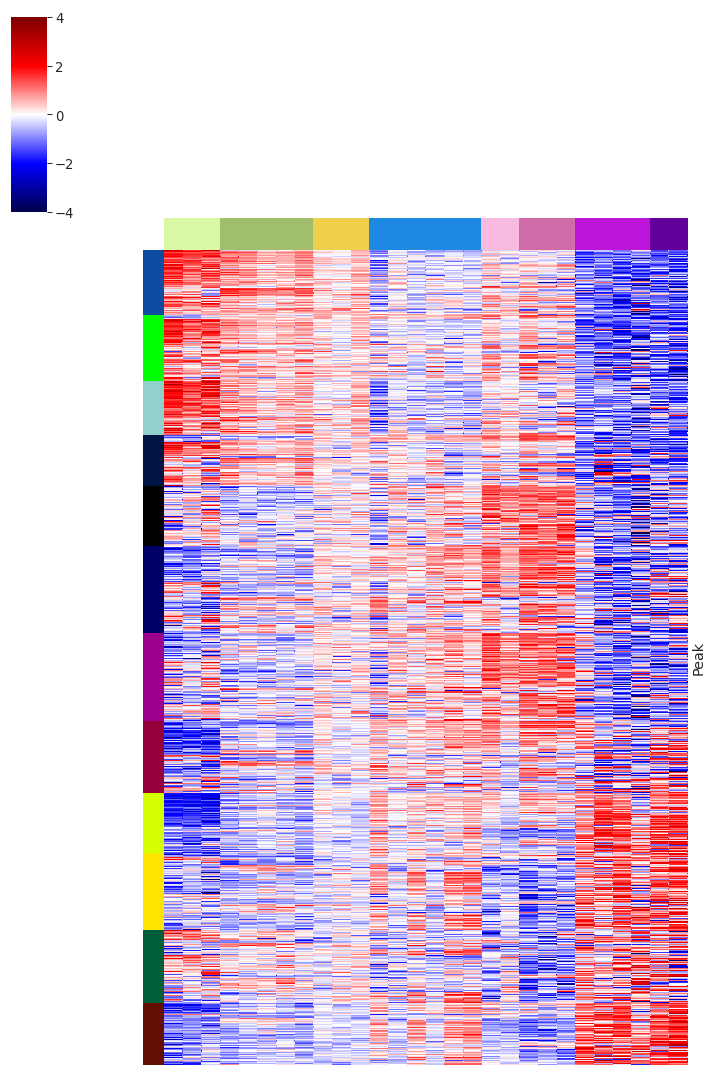

In [34]:
sns.clustermap(peaks_log.iloc[peak_ordering_concat,:], col_cluster=False, row_cluster=False,
               xticklabels="", yticklabels="",figsize=(10,15),
               col_colors=labels_colors,row_colors=np.array(row_clusters)[peak_ordering_concat],
               cmap='seismic', z_score=0,vmax=4,vmin=-4)

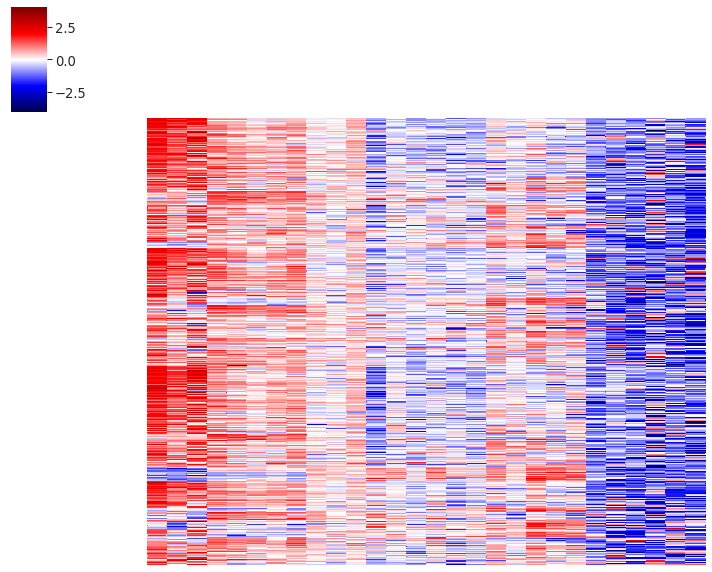

In [35]:
sns.clustermap(peaks_log.iloc[peak_ordering[0],:].values, col_cluster=False, row_cluster=False,
               xticklabels="", yticklabels="",figsize=(10,len(peak_ordering[0])/2500),
               cmap='seismic', z_score=0,vmin=-4,vmax=4)

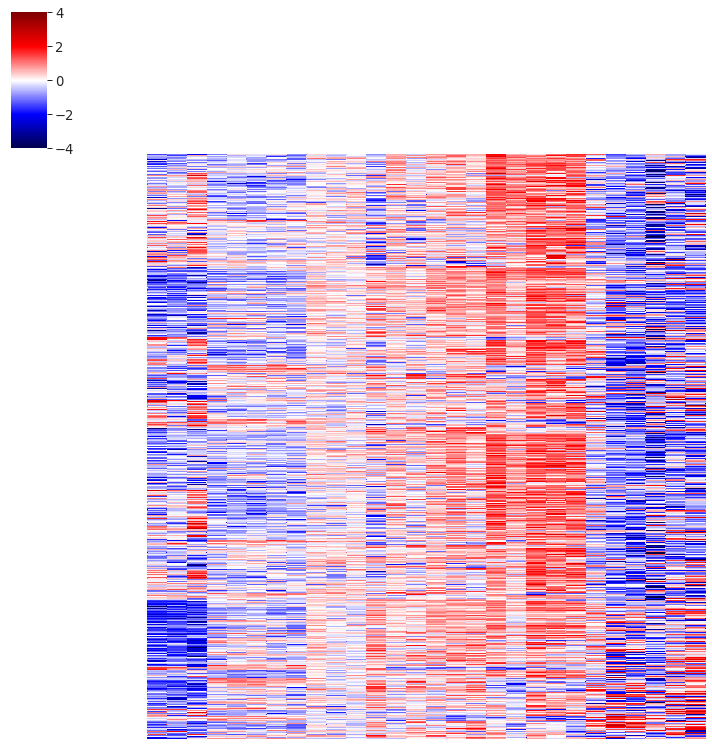

In [36]:
sns.clustermap(peaks_log.iloc[peak_ordering[1],:].values, col_cluster=False, row_cluster=False,
               xticklabels="", yticklabels="",figsize=(10,len(peak_ordering[1])/2500),
               cmap='seismic', z_score=0,vmin=-4,vmax=4)

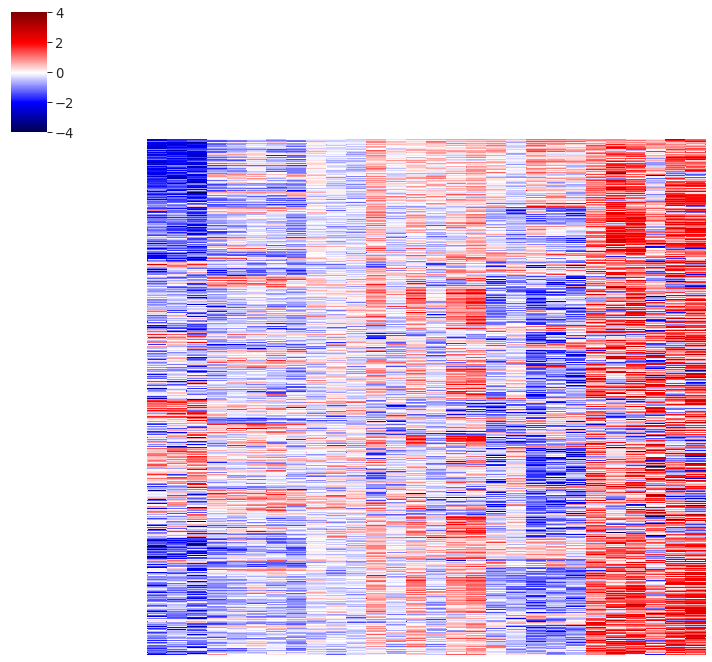

In [37]:
sns.clustermap(peaks_log.iloc[peak_ordering[2],:].values, col_cluster=False, row_cluster=False,
               xticklabels="", yticklabels="",figsize=(10,len(peak_ordering[2])/2500),
               cmap='seismic', z_score=0,vmin=-4,vmax=4)

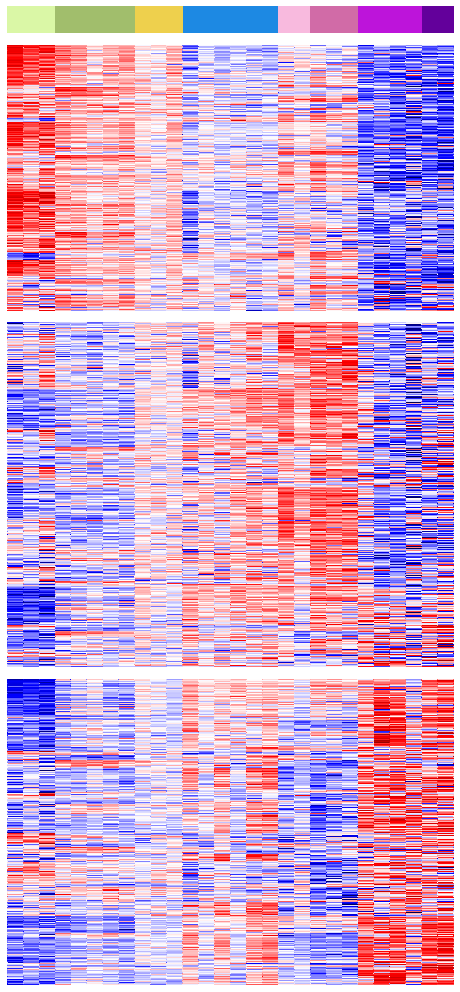

In [38]:
mat_logged_zscored_heatmap = ((peaks_log.values.T - peaks_log.values.mean(1))/peaks_log.values.std(1)).T


fig,ax=plt.subplots(4,1,figsize=(8,18),
        gridspec_kw={'height_ratios':(2000,len(peak_ordering[0]),len(peak_ordering[1]),len(peak_ordering[2]))},
        sharex=False, sharey=False)


col_rgb_colors = np.asarray([matplotlib.colors.to_rgb(i) for i in labels_colors])
ax[0].imshow(np.tile(col_rgb_colors[None, :, :], [1000, 1, 1]),aspect="auto", interpolation='none')
ax[0].set_axis_off()

#axis 0: heatmap
sns.heatmap(mat_logged_zscored_heatmap[peak_ordering[0],:],cmap='seismic',
              xticklabels="",
              yticklabels="",
              ax=ax[1], cbar=False,vmin=-4,vmax=4)

#axis 1: heatmap
sns.heatmap(mat_logged_zscored_heatmap[peak_ordering[1],:],cmap='seismic',
              xticklabels="",
              yticklabels="",
              ax=ax[2], cbar=False,vmin=-4,vmax=4)

#axis 3: heatmap
sns.heatmap(mat_logged_zscored_heatmap[peak_ordering[2],:],cmap='seismic',
              xticklabels="",
              yticklabels="",
              ax=ax[3], cbar=False,vmin=-4,vmax=4)

plt.subplots_adjust(wspace=0, hspace=.05)

plt.savefig(working_dir+"final_figures/Figure2/BulkATAC_Heatmap_HighContrast.png",bbox_inches='tight')

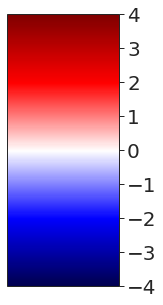

In [39]:
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = plt.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
plt.savefig(working_dir+"final_figures/Figure2/BulkATAC_Heatmap_HighContrast_cbar.pdf",bbox_inches='tight')

## Visualize Module Expression

In [40]:
sc.layout_log['x'] = sc.layout_log.values[:,0] * -1

In [41]:
Normal_unique = list(set(module_gene_dict['Normal'])-set(module_gene_dict['Benign Neoplasia'])-set(module_gene_dict['Malignant']))
Benign_unique = list(set(module_gene_dict['Benign Neoplasia'])-set(module_gene_dict['Normal'])-set(module_gene_dict['Malignant']))
Malig_unique = list(set(module_gene_dict['Malignant'])-set(module_gene_dict['Normal'])-set(module_gene_dict['Benign Neoplasia']))

1643
1301
1475


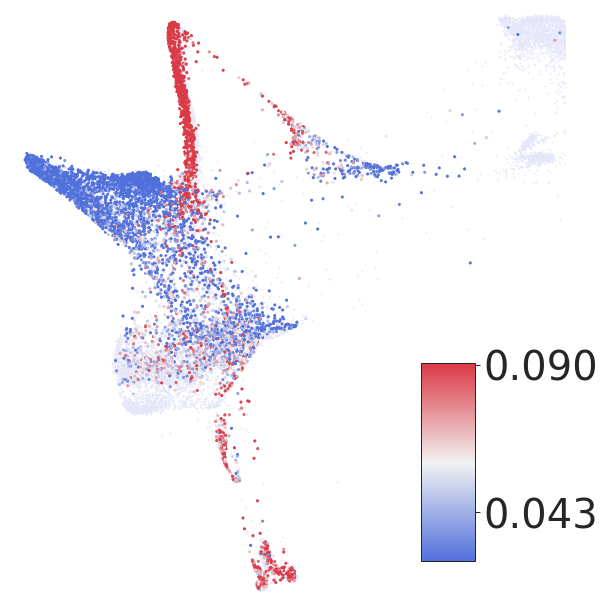

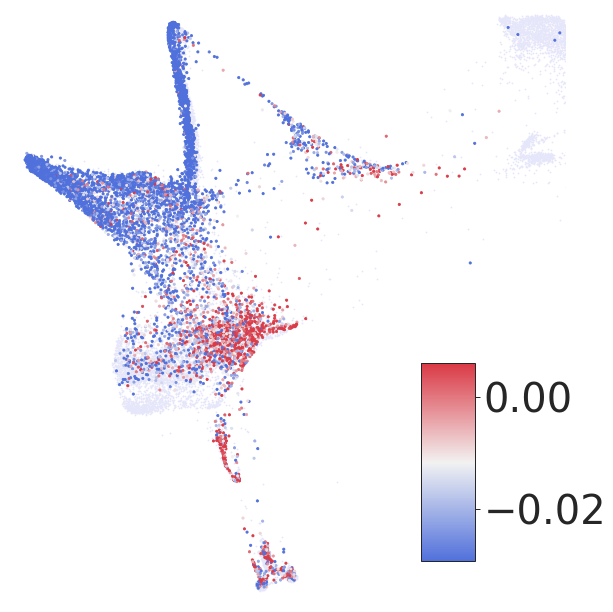

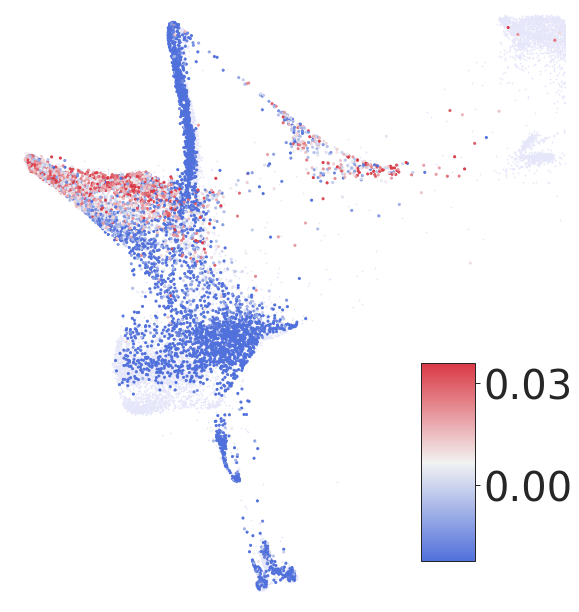

In [42]:
cmap = sns.diverging_palette(260, 10, as_cmap=True)
xlims=(-30582.43860067619,14290.163258315315)
ylims=(-39189.39192678506, 20807.458991902786)

for i,geneset in enumerate([Normal_unique,Benign_unique,Malig_unique]):
    geneset = np.intersect1d(geneset,list(sc.data_normalized))
    print(len(geneset))
    color=data_logged_zscored[geneset].mean(1).values
    vmin = np.percentile(color,40)
    vmax = np.percentile(color,90)
    
    cells_plot = np.concatenate((injury,kras))
    
    order__ = np.random.choice(cells_plot,size=len(cells_plot),replace=False)
    
    fig,ax=plt.subplots(figsize=(10,11))

    ax.scatter(sc.layout_log.values[:,0],sc.layout_log.values[:,1],
                  c='lavender',s=1)
    scatterplt = ax.scatter(sc.layout_log.values[:,0][order__],sc.layout_log.values[:,1][order__],
                  c=color[order__],cmap=cmap,vmin=vmin,vmax=vmax,s=5)
    ax.set_axis_off()
    
    cax = fig.add_axes([.7, .18, 0.075, 0.25])
    cbar = fig.colorbar(scatterplt, cax,ticks=[float(str(np.percentile([vmin,vmax],25))[:5]),
                                               float(str(vmax)[:4])])
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(40)
    #ax.set_yticks([])

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    plt.savefig(working_dir+"final_figures/Figure2/FDL_BulkATAC_ModulesUnique_{}.png".format(i),bbox_inches='tight')

In [43]:
pd.DataFrame(dict(Normal=Normal_unique)).to_csv(working_dir+"final_outputs/Figure2/Normal_Module_unique.csv")
pd.DataFrame(dict(Benign=Benign_unique)).to_csv(working_dir+"final_outputs/Figure2/Benign_Module_unique.csv")
pd.DataFrame(dict(Malignant=Malig_unique)).to_csv(working_dir+"final_outputs/Figure2/Malignant_Module_unique.csv")

In [44]:
pd.DataFrame(dict(Normal=module_gene_dict['Normal'])).to_csv(working_dir+"final_outputs/Figure2/Normal_Module_all.csv")
pd.DataFrame(dict(Benign=module_gene_dict['Benign Neoplasia'])).to_csv(working_dir+"final_outputs/Figure2/Benign_Module_all.csv")
pd.DataFrame(dict(Malignant=module_gene_dict['Malignant'])).to_csv(working_dir+"final_outputs/Figure2/Malignant_Module_all.csv")